In [ ]:
!pip install geopy mlxtend catboost

     |████████████████████████████████| 66.1MB 58kB/s 


In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random

seed = 1

random.seed(seed)
np.random.seed(seed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!unzip '/content/drive/My Drive/Final Data.zip' -d '/content/drive/My Drive/USAID'

In [ ]:
# Loading all the data
sd = pd.read_csv('/content/drive/My Drive/USAID/service_delivery_site_data.csv')
products = pd.read_csv('/content/drive/My Drive/USAID/product.csv')
train = pd.read_csv('/content/drive/My Drive/USAID/Train.csv') 

zindi_submission = pd.read_csv('/content/drive/My Drive/usaid/SampleSubmission.csv')

In [ ]:
print(sd.shape,train.shape,products.shape,zindi_submission.shape)

(156, 6) (35753, 14) (11, 3) (3089, 2)


In [ ]:
print(train.shape)
train.head()

(35753, 14)


,year,month,region,district,site_code,product_code,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_stockout_days,stock_ordered
0,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,75,0,21,-54,0,18,0,100.0
1,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27132,3,0,3,0,0,2,0,10.0
2,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27000,0,75,22,0,53,9,0,0.0
3,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27137,2,0,0,0,2,0,0,0.0
4,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27138,45,0,2,0,43,1,0,0.0


In [ ]:
sd.head()

,site_code,site_type,site_region,site_district,site_latitude,site_longitude
0,C1399,Health Center,ABIDJAN 2,COCODY-BINGERVILLE,5.352721,-3.940210
1,C4001,Hospital,INDENIE-DJUABLIN,ABENGOUROU,6.730937,-3.483863
2,C1004,Hospital,AGNEBY-TIASSA-ME,AGBOVILLE,5.928340,-4.211450
3,C4002,Hospital,BOUNKANI-GONTOUGO,BONDOUKOU,8.041860,-2.798370
4,C2002,Hospital,MARAHOUE,BOUAFLE,6.984120,-5.751980


In [ ]:
train.drop(columns={'stock_initial', 'stock_received','stock_adjustment', 
                    'stock_end','average_monthly_consumption',
                    'stock_stockout_days', 'stock_ordered'},inplace=True)

In [ ]:
train.head()

,year,month,region,district,site_code,product_code,stock_distributed
0,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,21
1,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27132,3
2,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27000,22
3,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27137,0
4,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27138,2


In [ ]:
test=pd.DataFrame(zindi_submission.ID.str.split('X',3).tolist(), columns = ['year','month','site_code','product_code'])


for col in test.columns:
    test[col] = test[col].str.strip()
column=['year','month'] 
for col in column:
    test[col]=test[col].astype(int)
test=pd.merge(test,sd,on='site_code',how='left')
test.rename(columns={'site_region':'region','site_district':'district'},inplace=True)
test=test[['year', 'month','region','district','site_code', 'product_code']]

In [ ]:
test.shape

(3089, 6)

In [ ]:
train.head(2).append(test.head(2))

,year,month,region,district,site_code,product_code,stock_distributed
0,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,21.0
1,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27132,3.0
0,2019,7,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS21126,NaN
1,2019,7,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,NaN


In [ ]:
train['train_or_test']='train'
test['train_or_test']='test'
df=pd.concat([train,test])

In [ ]:
df.isna().sum()

year                    0
month                   0
region                  0
district                0
site_code               0
product_code            0
stock_distributed    3089
train_or_test           0
dtype: int64

In [ ]:
# Extracing site information - site type and site coordinates

df['site_type'] = np.nan
df['lat'] = np.nan
df['long'] = np.nan


df.set_index('site_code', inplace=True)
sd.set_index('site_code', inplace = True)

for i,v in enumerate(df.index):

  for j in sd.index:

    if v == j:
      df.loc[v, 'site_type'] = sd.loc[v, 'site_type']
      df.loc[v, 'lat'] = sd.loc[v,'site_latitude']
      df.loc[v, 'long'] = sd.loc[v, 'site_longitude']


In [ ]:
df.head(2)

,year,month,region,district,product_code,stock_distributed,train_or_test,site_type,lat,long
site_code,,,,,,,,,,
C4001,2019,1,INDENIE-DJUABLIN,ABENGOUROU,AS27134,21.0,train,Hospital,6.730937,-3.483863
C4001,2019,1,INDENIE-DJUABLIN,ABENGOUROU,AS27132,3.0,train,Hospital,6.730937,-3.483863


In [ ]:
df.reset_index(inplace=True)

In [ ]:
 # Extract product type information from the product information

df['product_type'] = np.nan


df.set_index('product_code', inplace=True)
products.set_index('product_code', inplace = True)

for i,v in enumerate(df.index):

  for j in products.index:

    if v == j:
      df.loc[v, 'product_type'] = products.loc[v, 'product_type']

In [ ]:
df.reset_index(inplace = True)

In [ ]:
print(df.shape)
df.head()

(38842, 12)


,product_code,site_code,year,month,region,district,stock_distributed,train_or_test,site_type,lat,long,product_type
0,AS27134,C4001,2019,1,INDENIE-DJUABLIN,ABENGOUROU,21.0,train,Hospital,6.730937,-3.483863,Injectable Contraceptive
1,AS27132,C4001,2019,1,INDENIE-DJUABLIN,ABENGOUROU,3.0,train,Hospital,6.730937,-3.483863,Oral Contraceptive (Pill)
2,AS27000,C4001,2019,1,INDENIE-DJUABLIN,ABENGOUROU,22.0,train,Hospital,6.730937,-3.483863,Oral Contraceptive (Pill)
3,AS27137,C4001,2019,1,INDENIE-DJUABLIN,ABENGOUROU,0.0,train,Hospital,6.730937,-3.483863,Contraceptive Implant
4,AS27138,C4001,2019,1,INDENIE-DJUABLIN,ABENGOUROU,2.0,train,Hospital,6.730937,-3.483863,Contraceptive Implant


In [ ]:
from geopy.distance import vincenty

# Feature engineering

df['vicenty_distance'] = df.apply(lambda x : vincenty(x['lat'], x['long']), axis = 1)
df['vicenty_distance'] = df.vicenty_distance.apply(lambda x : x.kilometers)
#df['squared_distance'] = np.sqrt(np.power(df['lat'], 2) + np.power(df['long'], 2))
#df['log_squared_distance'] = np.log(df['squared_distance']+1)
#df['log_vicenty_distance'] = np.log(df['vicenty_distance']+1)

/usr/local/lib/python3.6/dist-packages/geopy/point.py:180: UserWarning: A single number has been passed to the Point constructor. This is probably a mistake, because constructing a Point with just a latitude seems senseless. If this is exactly what was meant, then pass the zero longitude explicitly to get rid of this warning.
  UserWarning)


In [ ]:
df.head()

,product_code,site_code,year,month,region,district,stock_distributed,train_or_test,site_type,lat,long,product_type,vicenty_distance
0,AS27134,C4001,2019,1,INDENIE-DJUABLIN,ABENGOUROU,21.0,train,Hospital,6.730937,-3.483863,Injectable Contraceptive,1129.533165
1,AS27132,C4001,2019,1,INDENIE-DJUABLIN,ABENGOUROU,3.0,train,Hospital,6.730937,-3.483863,Oral Contraceptive (Pill),1129.533165
2,AS27000,C4001,2019,1,INDENIE-DJUABLIN,ABENGOUROU,22.0,train,Hospital,6.730937,-3.483863,Oral Contraceptive (Pill),1129.533165
3,AS27137,C4001,2019,1,INDENIE-DJUABLIN,ABENGOUROU,0.0,train,Hospital,6.730937,-3.483863,Contraceptive Implant,1129.533165
4,AS27138,C4001,2019,1,INDENIE-DJUABLIN,ABENGOUROU,2.0,train,Hospital,6.730937,-3.483863,Contraceptive Implant,1129.533165


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in ['region','district','site_code','product_code','site_type','product_type',]:
  df[col]=  df[col].astype('str')
  df[col]= le.fit_transform(df[col])

In [ ]:
train=df.loc[df.train_or_test.isin(['train'])]
test=df.loc[df.train_or_test.isin(['test'])]
train.drop(columns={'train_or_test'},axis=1,inplace=True)
test.drop(columns={'train_or_test'},axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print(len(test),len(zindi_submission))

3089 3089


In [ ]:
print(train.shape)
train.head()

(35753, 12)


,product_code,site_code,year,month,region,district,stock_distributed,site_type,lat,long,product_type,vicenty_distance
0,5,119,2019,1,11,0,21.0,1,6.730937,-3.483863,3,1129.533165
1,3,119,2019,1,11,0,3.0,1,6.730937,-3.483863,6,1129.533165
2,2,119,2019,1,11,0,22.0,1,6.730937,-3.483863,6,1129.533165
3,6,119,2019,1,11,0,0.0,1,6.730937,-3.483863,0,1129.533165
4,7,119,2019,1,11,0,2.0,1,6.730937,-3.483863,0,1129.533165


In [ ]:
y_2016 = train.loc[train['year'] == 2016, 'stock_distributed']
y_2017 = train.loc[train['year'] == 2017, 'stock_distributed']
y_2018 = train.loc[train['year'] == 2018, 'stock_distributed']
y_2019 = train.loc[train['year'] == 2019, 'stock_distributed']

print(y_2016.shape, y_2017.shape,y_2018.shape,y_2019.shape)

(8031,) (10356,) (11192,) (6174,)


(8031,)


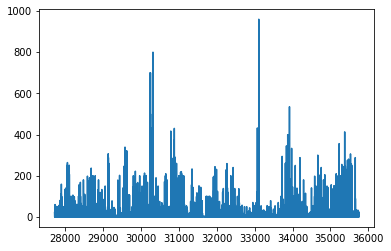

In [ ]:
print(y_2016.shape)
y_2016.plot()

In [ ]:
print(y_2017.shape)

y_2017.plot()

In [ ]:
print(y_2018.shape)

y_2018.plot()

In [ ]:
print(y_2019.shape)

y_2019.plot()

In [ ]:
X=train.drop(columns={'stock_distributed'})
y=train.loc[:,['stock_distributed']]
del test['stock_distributed']


In [ ]:
# Group the dat into yearly data across the different sites for all the products

X_2016 = X[X.year == 2016]
X_2017 = X[X.year == 2017]
X_2018 = X[X.year == 2018]
X_2019 = X[X.year == 2019]


test_2019 = test[test.year == 2019]

print(X_2016.shape, X_2017.shape,X_2018.shape,X_2019.shape,test_2019.shape)

(8031, 11) (10356, 11) (11192, 11) (6174, 11) (3089, 11)


In [ ]:
y_train_2016 = y_2016.values
y_train_2017 = y_2017.values
y_train_2018 = y_2018.values
y_train_2019 = y_2019.values

In [ ]:
# Drop the year in each year group of the data

x_16 = X_2016.drop(columns=['year'], axis = 1)
x_17 = X_2017.drop(columns=['year'], axis = 1)
x_18 = X_2018.drop(columns=['year'], axis = 1)
x_19 = X_2019.drop(columns=['year'], axis = 1)

x_19_test = test_2019.drop(columns=['year'], axis = 1)

In [ ]:
X_16 = x_16.values
X_17 = x_17.values
X_18 = x_18.values
X_19 = x_19.values

X_19_test = x_19_test.values

In [ ]:
# Model

seed = 1

from mlxtend.regressor import StackingCVRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.linear_model import LassoCV,LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold



def get_catboost():
  return CatBoostRegressor(random_seed=seed,depth = 4)


lin_reg = LinearRegression(normalize =True,fit_intercept =False)

svr = SVR(C = 1,kernel='poly', degree = 5) 


lasso = LassoCV(
  alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,0.3, 0.6, 1]
  ,max_iter=1000 
  ,tol = 1e-2
  ,random_state=seed,
  fit_intercept = True
  ,cv= KFold(n_splits= 5, shuffle =True,random_state=seed)
  ,verbose=True,
  normalize = True,
  n_jobs = -1
)


dt_meta = DecisionTreeRegressor(max_depth=4,random_state = seed)

rf = RandomForestRegressor(random_state=seed,n_estimators = 100, verbose=seed)

xgb_regressor = XGBRegressor(n_estimators = 500,colsample_bytree=1,
                             objective='reg:squarederror', eval_metric ='rmse',
                             #importance_type='weight',
                             random_state= seed,verbose=seed)

lgbm_regressor = LGBMRegressor(objective ='regression',
                               #importance_type='weight',
                               boosting_type='rf',bagging_fraction=0.8,bagging_freq = 1,
                               n_leaves =31, n_estimators= 500, learning_rate =0.015,random_state=seed,metric='rmse',verbose=seed)

cat_boost = get_catboost()

ada_boost = AdaBoostRegressor(dt_meta,random_state = seed,n_estimators = 100)


forecaster = StackingCVRegressor(regressors=(lin_reg,lasso,svr,lgbm_regressor,xgb_regressor,cat_boost,ada_boost,rf),
                            meta_regressor= lin_reg,
                            shuffle = True,
                            cv = 5,
                            use_features_in_secondary=True
                            ) 

In [ ]:
%%time
np.random.seed(seed)

print("###### Start training 2016 ###### ")
forecaster.fit(X_16, y_train_2016)
print("###### 2016 Complete")

print("###### Start training 2017 ###### ")
forecaster.fit(X_17,y_train_2017)
print("###### 2017 Complete")

print("###### Start training 2018 ###### ")
forecaster.fit(X_18,y_train_2018)
print("###### 2018 Complete")


In [ ]:
%%time
np.random.seed(seed)

predictions = forecaster.fit(X_19,y_train_2019).predict(X_19_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
.................................................................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
.................................................................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
.................................................................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
.................................................................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
...................................................

Streaming output truncated to the last 5000 lines.
5:	learn: 36.2928272	total: 9.4ms	remaining: 1.56s
6:	learn: 36.1283044	total: 11ms	remaining: 1.55s
7:	learn: 35.9914807	total: 12.5ms	remaining: 1.54s
8:	learn: 35.8747464	total: 14ms	remaining: 1.54s
9:	learn: 35.7698222	total: 15.4ms	remaining: 1.53s
10:	learn: 35.6903044	total: 16.9ms	remaining: 1.52s
11:	learn: 35.5764236	total: 18.4ms	remaining: 1.51s
12:	learn: 35.5128844	total: 19.9ms	remaining: 1.51s
13:	learn: 35.4174285	total: 21.2ms	remaining: 1.49s
14:	learn: 35.3334889	total: 22.6ms	remaining: 1.48s
15:	learn: 35.2905026	total: 23.9ms	remaining: 1.47s
16:	learn: 35.1996715	total: 25.4ms	remaining: 1.47s
17:	learn: 35.1526422	total: 26.8ms	remaining: 1.46s
18:	learn: 35.0800407	total: 28.3ms	remaining: 1.46s
19:	learn: 35.0130929	total: 29.7ms	remaining: 1.46s
20:	learn: 34.9474598	total: 31.1ms	remaining: 1.45s
21:	learn: 34.8923998	total: 32.5ms	remaining: 1.45s
22:	learn: 34.8386645	total: 33.9ms	remaining: 1.44s
23:	l

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Learning rate set to 0.053966
0:	learn: 37.3373994	total: 1.69ms	remaining: 1.69s
1:	learn: 37.1410537	total: 3.47ms	remaining: 1.73s
2:	learn: 36.9333374	total: 5.24ms	remaining: 1.74s
3:	learn: 36.7588764	total: 6.89ms	remaining: 1.71s
4:	learn: 36.5495520	total: 8.54ms	remaining: 1.7s
5:	learn: 36.4143444	total: 10.2ms	remaining: 1.7s
6:	learn: 36.2340465	total: 11.9ms	remaining: 1.69s
7:	learn: 36.0718553	total: 13.6ms	remaining: 1.68s
8:	learn: 35.9617328	total: 15.2ms	remaining: 1.68s
9:	learn: 35.8605793	total: 16.8ms	remaining: 1.67s
10:	learn: 35.7824482	total: 18.4ms	remaining: 1.66s
11:	learn: 35.6821741	total: 20.1ms	remaining: 1.65s
12:	learn: 35.6139896	total: 21.6ms	remaining: 1.64s
13:	learn: 35.5182503	total: 23.3ms	remaining: 1.64s
14:	learn: 35.4563059	total: 24.8ms	remaining: 1.63s
15:	learn: 35.3737037	total: 26.4ms	remaining: 1.62s
16:	learn: 35.2796789	total: 28.1ms	remaining: 1.62s
17:	learn: 35.2461944	total: 29.7ms	remaining: 1.62s
18:	learn: 35.1529246	total:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished


CPU times: user 50 s, sys: 3.1 s, total: 53.1 s
Wall time: 46 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
# Generating submission file to validate on zindi

zindi_submission['prediction'] = np.around(np.abs(predictions)).astype(int)

In [ ]:
# Generate USAID submission file
test_submission = test[['year','month','site_code','product_code']]
test_submission['predicted_value'] = np.around(np.abs(predictions)).astype(int)

In [ ]:
test_submission.to_csv('Model_1_submission.csv',index = False)

In [ ]:
zindi_submission.head()

,ID,prediction
0,2019 X 7 X C4001 X AS21126,2
1,2019 X 7 X C4001 X AS27134,13
2,2019 X 7 X C4001 X AS27132,0
3,2019 X 7 X C4001 X AS27000,13
4,2019 X 7 X C4001 X AS27137,3


In [ ]:
zindi_submission.to_csv('Model_submission_1.csv',index=False)